<a href="https://colab.research.google.com/github/chrisMac93/Breast_Cancer_Tumors_Classification/blob/master/Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
#Import Dependencies
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import itertools

import pandas as pd

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

np.set_printoptions(threshold=np.inf)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

In [0]:
def Sigmoid(Z):
  return 1 / (1+np.exp(-Z))

def Relu(Z):
  return np.maximum(0, Z)

def Relu2(dZ, Z):
  dZ[Z <= 0] = 0
  return dZ

def dRelu(x):
  x[x <= 0] = 0
  x[x > 0] = 1
  return x

def dSigmoid(z):
  s = 1/(1+np.exp(-z))
  dZ = s * (1 - s)
  return dZ

In [0]:
class dlnet:
  def __init__(self, x, y):
    self.debug = 0
    self.X = x
    self.Y = y 
    self.Yh = np.zeros((1, self.Y.shape[1]))

    self.L = 2
    self.dims = [9, 15, 1]

    self.param = {}
    self.ch = {}
    self.grad = {}

    self.loss = []
    self.lr = 0.003
    self.sam = self.Y.shape[1]
    self.threshold = 0.5

  def nInit(self):
    np.random.seed(1)
    self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0])
    self.param['b1'] = np.zeros((self.dims[1], 1))
    self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1])
    self.param['b2'] = np.zeros((self.dims[2], 1))

  def forward(self):
    Z1 = self.param['W1'].dot(self.X) + self.param['b1']
    A1 = Relu(Z1)
    self.ch['Z1'], self.ch['A1'] = Z1, A1

    Z2 = self.param['W2'].dot(A1) + self.param['b2']
    A2 = Sigmoid(Z2)
    self.ch['Z2'], self.ch['A2'] = Z2, A2

    self.Yh = A2
    loss = self.nloss(A2)
    return self.Yh, loss

  def nloss(self, Yh):
    loss = (1./self.sam) * (-np.dot(self.Y, np.log(Yh).T) - np.dot(1 - self.Y, np.log(1-Yh).T))
    return loss
  def backward(self):
    dLoss_Yh = - (np.divide(self.Y, self.Yh) - np.divide(1 - self.Y, 1 - self.Yh))
    dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])
    dLoss_A1 = np.dot(self.param['W2'].T, dLoss_Z2)
    dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, self.ch['A1'].T)
    dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1]))

    dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
    dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
    dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
    dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))

    self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
    self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
    self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
    self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2

    return

  def pred(self, x, y):
    self.X = x
    self.Y = y
    comp = np.zeros((1, x.shape[1]))
    pred, loss = self.forward()

    for i in range(0, pred.shape[1]):
      if pred[0,i] > self.threshold: comp[0,i] = 1
      else: comp[0,i] = 0

    print("Acc: " + str(np.sum((comp == y) / x.shape[1])))

    return comp

  def gd(self, X, Y, iter = 3000):
    np.random.seed()

    self.nInit()

    for i in range(0, iter):
      Yh, loss = self.forward()
      self.backward()

      if i % 500 == 0:
        print("Cost after iteration %i: %f" %(i, loss))
        self.loss.append(loss)

    plt.plot(np.squeeze(self.loss))
    plt.ylabel('Loss')
    plt.xlabel('Iter')
    plt.title("Lr =" + str(self.lr))
    plt.show()

    return

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1hkeFfE0ij7z5QZdVau2iBfCfiper_yYx"})
downloaded.GetContentFile('breast-cancer-wisconsin.csv')

In [0]:
df = pd.read_csv('breast-cancer-wisconsin.csv', header = None)
df = df[~df[6].isin(['?'])]
df = df.astype(float)
df.iloc[:,10].replace(2, 0, inplace=True)
df.iloc[:,10].replace(4, 1, inplace=True)

df.head(3)
scaled_df = df
names = df.columns[0:10]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df.iloc[:,0:10])
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [120]:
df.head(15)

,0,1,2,3,4,5,6,7,8,9,10
0,1000025.0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,1002945.0,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,1015425.0,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,1016277.0,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,1017023.0,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0
5,1017122.0,8.0,10.0,10.0,8.0,7.0,10.0,9.0,7.0,1.0,1.0
6,1018099.0,1.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,1.0,0.0
7,1018561.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
8,1033078.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,0.0
9,1033078.0,4.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0


In [121]:
x = scaled_df.iloc[0:500,1:10].values.transpose()
y = df.iloc[0:500,10:].values.transpose()

xval = scaled_df.iloc[501:603,1:10].values.transpose()
yval = df.iloc[501:603,10:].values.transpose()

print(df.shape, x.shape, y.shape, xval.shape, yval.shape)

nn = dlnet(x,y)

nn.lr = 0.01
nn.dims = [9, 15, 1]

(683, 11) (9, 500) (1, 500) (9, 102) (1, 102)


Cost after iteration 0: 0.673967
Cost after iteration 500: 0.388928
Cost after iteration 1000: 0.231340
Cost after iteration 1500: 0.171447
Cost after iteration 2000: 0.146433
Cost after iteration 2500: 0.133993
Cost after iteration 3000: 0.126808
Cost after iteration 3500: 0.122107
Cost after iteration 4000: 0.118650
Cost after iteration 4500: 0.116027
Cost after iteration 5000: 0.113934
Cost after iteration 5500: 0.112221
Cost after iteration 6000: 0.110783
Cost after iteration 6500: 0.109546
Cost after iteration 7000: 0.108474
Cost after iteration 7500: 0.107537
Cost after iteration 8000: 0.106710
Cost after iteration 8500: 0.105977
Cost after iteration 9000: 0.105317
Cost after iteration 9500: 0.104718
Cost after iteration 10000: 0.104174
Cost after iteration 10500: 0.103674
Cost after iteration 11000: 0.103216
Cost after iteration 11500: 0.102785
Cost after iteration 12000: 0.102377
Cost after iteration 12500: 0.101980
Cost after iteration 13000: 0.101604
Cost after iteration 1350

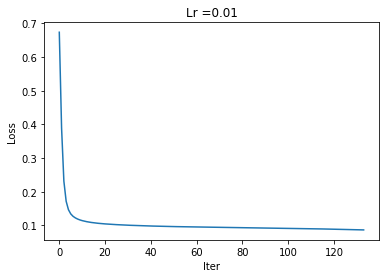

In [122]:
nn.gd(x, y, iter = 67000)

In [124]:
pred_train = nn.pred(x, y)
pred_test = nn.pred(xval, yval)

Acc: 0.9640000000000003
Acc: 0.9999999999999996


In [132]:
nn.X,nn.Y=xval, yval 
yvalh, loss = nn.forward()
print("\ny",np.around(yval[:,0:50,], decimals=0).astype(np.int))       
print("\nyh",np.around(yvalh[:,0:50,], decimals=0).astype(np.int),"\n")


y [[0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

yh [[0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 



In [0]:
def plotCf

Acc: 0.9640000000000003


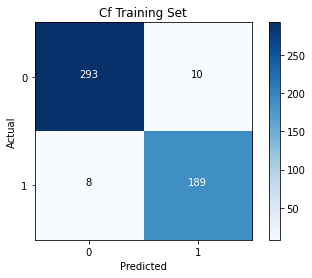

Acc: 0.9999999999999996


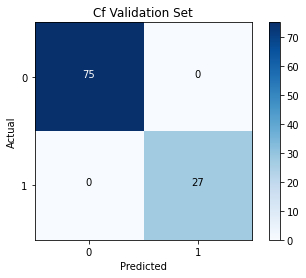

In [126]:
nn.threshold = 0.5

nn.X, nn.Y = x, y
target = np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted = np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target, predicted, 'Cf Training Set')

nn.X, nn.Y = xval, yval
target = np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted = np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target, predicted, 'Cf Validation Set')

Acc: 0.9620000000000003


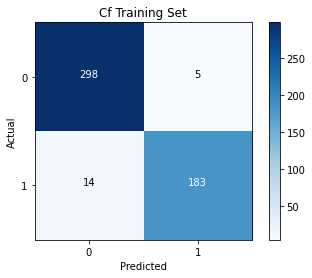

Acc: 0.9999999999999996


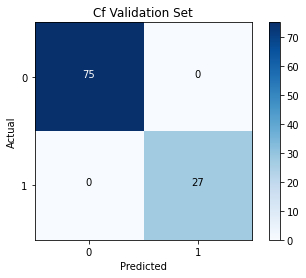

In [127]:
nn.threshold = 0.7

nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')

Acc: 0.9360000000000003


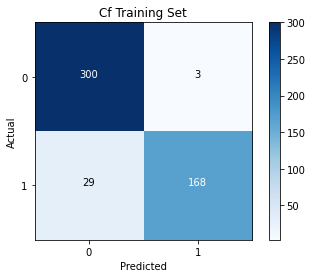

Acc: 0.9901960784313721


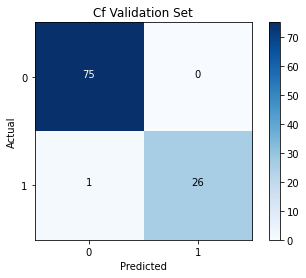

In [128]:
nn.threshold=0.9

nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')